In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Data Loading and Exploration

In [2]:
import pandas as pd

# Load the dataset
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# Check the first few rows of the training set
print(train.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [3]:
# Check for missing values
print(train.isnull().sum())

# Summary statistics
print(train.describe())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


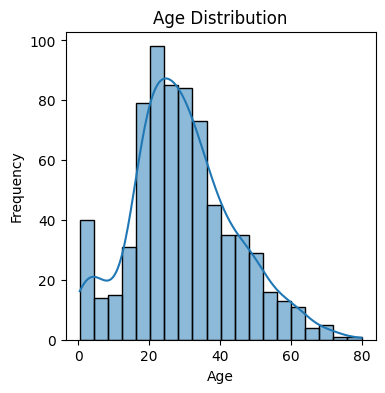

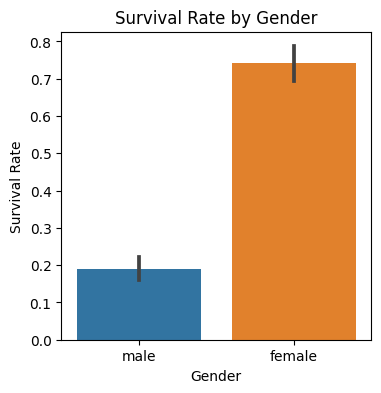

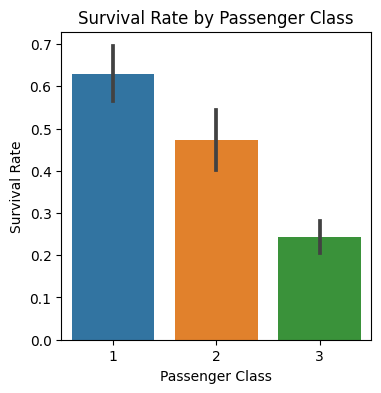

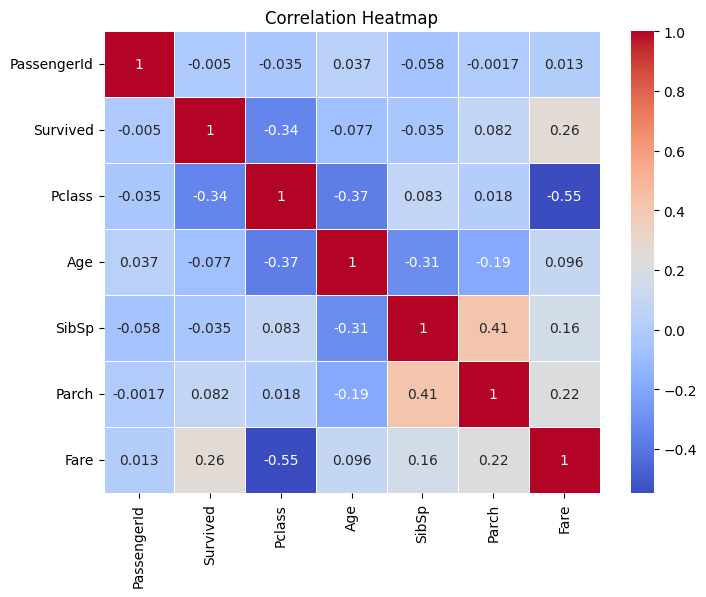

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of Age
plt.figure(figsize=(4, 4))
sns.histplot(train['Age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


# Visualize survival rates by gender
plt.figure(figsize=(4, 4))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.show()

# Visualize survival rates by class
plt.figure(figsize=(4, 4))
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

# Heatmap
# Select only the numeric columns for correlation calculation
numeric_columns = train.select_dtypes(include=[np.number])
# Visualize correlation between numerical features
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# Data Preprocessing

In [5]:
# Fill missing Age values with the median
train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(test['Age'].median())

# Fill missing Embarked values with the most common value
if 'Embarked' in train.columns:
    train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
if 'Embarked' in test.columns:
    test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode()[0])

# Drop Cabin column (due to the too many missing values)
if 'Cabin' in train.columns:
    train = train.drop(columns=['Cabin'])
if 'Cabin' in test.columns:
    test = test.drop(columns=['Cabin'])

# Convert categorical 'Sex' into numerical values
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

# Convert 'Embarked' using one-hot encoding 
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)
test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)

# Define the features (X) and target (y)
X = train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Survived'])
y = train['Survived']

# Align test data with train data (some columns may not match after encoding)
X_test = test.drop(columns=['PassengerId', 'Name', 'Ticket'])
X_train, X_test = X.align(X_test, join='inner', axis=1)  # Ensures test matches training data structure


# Model Training: XGBoost

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_xgb = xgb_model.predict(X_val)

# XGBoost Hyperparameter Tuning

In [7]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')

# Perform the grid search
grid_search_xgb.fit(X_train, y_train)

# Best parameters
print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")

# Train with best parameters
best_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_val)

# Evaluate
accuracy_best_xgb = accuracy_score(y_val, y_pred_best_xgb)
precision_best_xgb = precision_score(y_val, y_pred_best_xgb)
recall_best_xgb = recall_score(y_val, y_pred_best_xgb)

print(f'Tuned XGBoost Accuracy: {accuracy_best_xgb}')
print(f'Tuned XGBoost Precision: {precision_best_xgb}')
print(f'Tuned XGBoost Recall: {recall_best_xgb}')


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Tuned XGBoost Accuracy: 0.8212290502793296
Tuned XGBoost Precision: 0.85
Tuned XGBoost Recall: 0.6891891891891891


#  Model Optimization: Threshold Tuning Using ROC Curve

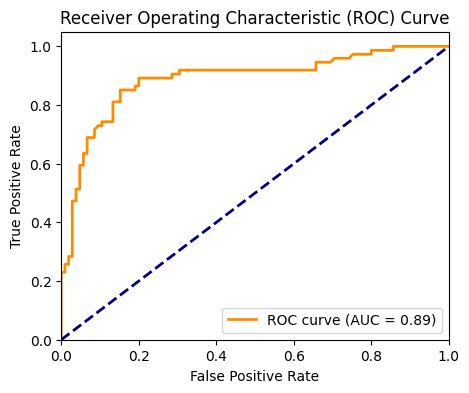

Optimal Threshold: 0.3574305772781372


In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

best_xgb.fit(X_train, y_train)

# Get predicted probabilities for class 1 (Survived)
y_val_probs = best_xgb.predict_proba(X_val)[:, 1]

# Calculate ROC curve data
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
roc_auc = roc_auc_score(y_val, y_val_probs)

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate Youden’s J statistic: J = TPR - FPR
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

# Apply the optimal threshold to make predictions
y_val_optimal_pred = (y_val_probs >= optimal_threshold).astype(int)



The **ROC curve** helps to see how well the model is doing at telling the difference between positive and negative classes by showing the trade-off between catching the positives and mistakenly flagging negatives as positives. It's useful for picking the best threshold for the predictions.

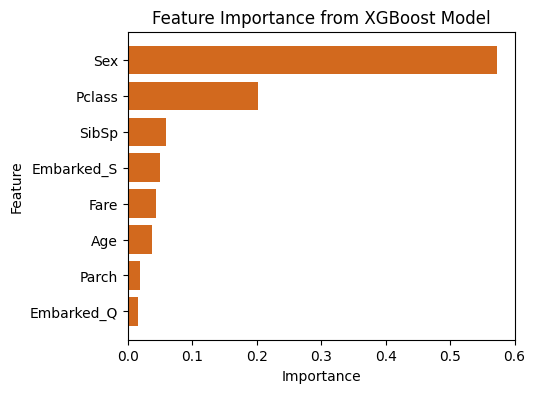

In [9]:
# Plot Feature Importance
import matplotlib.pyplot as plt
import xgboost as xgb

# Get the feature importance from the best XGBoost model
importance = best_xgb.feature_importances_
features = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(5, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='chocolate')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


**The Feature importance plot** shows which features (or columns) in the dataset have the most influence on the model's predictions. It's a way to see which factors the model thinks are most important in making decisions.

# Final Evaluation

In [10]:
from sklearn.metrics import mean_absolute_error

# Evaluate the model with the optimal threshold
accuracy_optimal = accuracy_score(y_val, y_val_optimal_pred)
precision_optimal = precision_score(y_val, y_val_optimal_pred)
recall_optimal = recall_score(y_val, y_val_optimal_pred)

# Calculate Mean Absolute Error (MAE)
mae_optimal = mean_absolute_error(y_val, y_val_optimal_pred)

print(f'Validation Accuracy (Optimal Threshold): {accuracy_optimal * 100:.2f}%')
print(f'Validation Precision (Optimal Threshold): {precision_optimal * 100:.2f}%')
print(f'Validation Recall (Optimal Threshold): {recall_optimal * 100:.2f}%')
print(f'Mean Absolute Error (MAE) with Optimal Threshold: {mae_optimal:.4f}')


Validation Accuracy (Optimal Threshold): 84.92%
Validation Precision (Optimal Threshold): 79.75%
Validation Recall (Optimal Threshold): 85.14%
Mean Absolute Error (MAE) with Optimal Threshold: 0.1508


**Validation Accuracy** (84.92%) means that 84.92% of predictions made by the model are correct. **Validation Precision** (79.75%) indicates that out of all the predicted positives, 79.75% were actually correct. **Validation Recall** (85.14%) shows that the model correctly identified 85.14% of all the actual positives. **Mean Absolute Error** (0.1508) means that, on average, the model’s predictions are off by about 15% from the actual values.

# Model Testing and Submission

In [11]:

# Make predictions on the test data
test_predictions = best_xgb.predict(X_test)

# Create a submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)


Note: This model achieved 78% accuracy on test data. To improve the model accuracy and reduce errors, advanced engineering and hyperparameter tuning or ensemble methods can be employed.

In [12]:
import joblib

# Save the trained XGBoost model as a .pkl file
joblib.dump(best_xgb, 'xgboost_model.pkl')

print("XGBoost model saved as 'xgboost_model.pkl'")


XGBoost model saved as 'xgboost_model.pkl'
